Welcome. This is a chill notebook for using BKA. We'll help you FM your companion and run an MCMC to fit the cleanest FM we can manage. Let's get to it.

First we need to make a forward model and KLIP our data.

In [1]:
from forwardModel import forwardModel

In [2]:
# dataset
date = '16May15'
prefixes = ['Cont_90pctcut']#, 'Ha']
filepaths = []
outputdirs = []
for pref in prefixes:
    filepath = f'data\\{date}\\{pref}\\*fits'
    outputdir = f'output\\{date}\\{pref}'
    filepaths.append(filepath)
    outputdirs.append(outputdir)
# parameters
KLmode = 5
sep = 10
pa = 110
contrast = 1e-2
an = [4,20]
move = 1
scale = 1
PSFpath = 'doMoffat'
FWHM = 5.24
cores = 4
highpass = False#1.5*FWHM
numbasis = KLmode

reading data, num files:  120
Parameters set, ready to begin forward modeling... 
saving files to: .\output\16May15\Cont_90pctcut
read fits file into data
created median
Calculated ghost center is 148.27761388834494 at x=382 , y=218
returning
Parameter('x_0', value=17.0)
x center is Parameter('x_0', value=15.225012623896443)
y center is Parameter('y_0', value=14.59270269349781)
Parameter('x_0', value=15.225012623896443) Parameter('y_0', value=14.59270269349781)
shift number 0
shift number 100
created median after shifting
Calculated ghost center is 152.06710892941544 at x=382 , y=218
returning
instrumental PSF FWHM is: 5.24
fm_class ready for KLIP
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 1206.3715789784806 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to direc

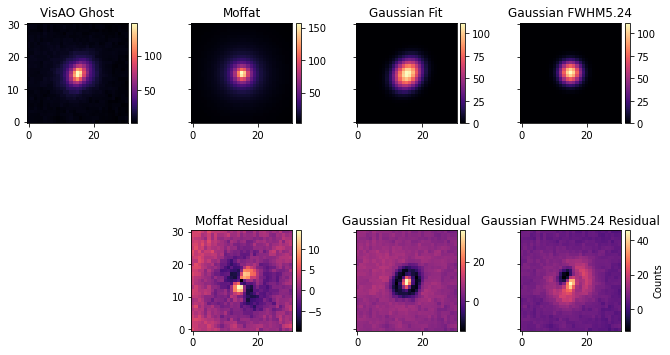

In [3]:
# run
for i in range(len(filepaths)):
    filepath = filepaths[i]
    outputdir = outputdirs[i]
    prefix = prefixes[i]
    fm = forwardModel(filepath, outputdir, prefix, KLmode, sep, pa, contrast, an, move, scale, ePSF=PSFpath, FWHM=FWHM, cores=cores, highpass=highpass, numbasis=numbasis)
    fm.prep_KLIP()
    fm.run_KLIP()

Text(0.5, 1.0, 'Moffat FWHM=5.24')

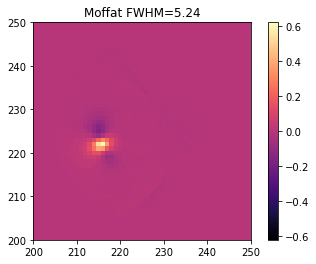

In [4]:
# we need to import some packages for this step
import os
import time
import pickle
import numpy as np
import astropy.io.fits as fits
import pyklip.fitpsf as fitpsf
import matplotlib.pylab as plt
import pyklip.instruments.MagAO as MagAO
output_prefix = os.path.join(outputdir, prefix)

def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius

def domask(img, inn=70, outt=180):
    outermask = create_circular_mask(451, 451, radius=outt, leq=True)
    img[~outermask] = np.nanmedian(img)
    mask = create_circular_mask(451, 451, radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = np.nanmedian(img)
    return masked_img

img = fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0]
n = np.nanmax(img)
plt.imshow(domask(img, inn=an[0], outt=an[1]), origin='lower', vmin=-n, vmax=n, cmap='magma')
plt.xlim(200,250)
plt.ylim(200,250)
plt.colorbar()
plt.title(PSFpath.replace('do','')+' FWHM='+str(FWHM))
# plt.savefig('FM-comparison-roughdata-'+PSFpath.replace('do','')+'.png', dpi=300)

Next, we'll run the MCMC to fit the FM to our KLIPed data

In [5]:
# we need to import some packages for this step
import os
import time
import pickle
import numpy as np
import astropy.io.fits as fits
import pyklip.fitpsf as fitpsf
import matplotlib.pylab as plt
import pyklip.instruments.MagAO as MagAO

You'll need to edit the variables in the cell below

In [6]:
# Your variables here
# some basics to point towards your model
sep = sep # only needs a guess
pa = pa # guess here too
length = 2.5 # guess here also

# set some boundaries for your MCMC
x_range = 2.5  # in pixels, anywhere from 1.5-5 is reasonable
y_range = 2.5  # same as x
flux_range = [10,100] # flux can vary by an order of magnitude
corr_len_range = 3 # between 0.3 and 30

# and finally some parameters for the MCMC run
nwalkers = 8

nburn = 1000
nsteps = 10000

# output to save chain to
pklout = outputdir+'\\'+prefix+'_chain.pkl'

These next two chunks of code will setup and run the MCMC. At the end it'll print out some details of the fit.

In [7]:
output_prefix = os.path.join(outputdir, prefix)

# get FM frame
fm_frame = fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0]
fm_header = fits.getheader(output_prefix + "-fmpsf-KLmodes-all.fits")
fm_centx = fm_header['PSFCENTX']
fm_centy = fm_header['PSFCENTY']

# get data_stamp frame
data_frame = fits.getdata(output_prefix + "-klipped-KLmodes-all.fits")[0]
data_header = fits.getheader(output_prefix + "-klipped-KLmodes-all.fits")
data_centx = data_header['PSFCENTX']
data_centy = data_header['PSFCENTY']

# get initial guesses. Should be in the header but aren't?
guesssep = sep
guesspa = pa

# create FM Astrometry object - 13 is fitboxsize
fma = fitpsf.FMAstrometry(guesssep, guesspa, 13)

# generate FM stamp
# padding should be greater than 0 so we don't run into interpolation problems
fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

# generate data_stamp stamp
# note that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
# exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=3)

# set kernel, no read noise
corr_len_guess = length
corr_len_label = r"$l$"
fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

# set bounds based on given boundaries
fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

In [8]:
t0 = time.time()

# run MCMC fit
fma.fit_astrometry(nwalkers=nwalkers, nburn=nburn, nsteps=nsteps, numthreads=4, chain_output=pklout)

t1 = time.time()
print("time taken: ", str(np.round(t1-t0)), " seconds")

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
time taken:  67.0  seconds


In [9]:
fma.propogate_errs(star_center_err=0.1, platescale=MagAO.MagAOData.lenslet_scale*1000, platescale_err=0.000015, pa_offset=-0.59, pa_uncertainty=0.3)


# show what the raw uncertainites are on the location of the planet
print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fma.raw_RA_offset.bestfit, fma.raw_RA_offset.error,
                                                                                    fma.raw_Dec_offset.bestfit, fma.raw_Dec_offset.error))

# Full error budget included
print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fma.RA_offset.bestfit, fma.RA_offset.error))
print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fma.Dec_offset.bestfit, fma.Dec_offset.error))

# Propogate errors into separation and PA space
print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fma.sep.bestfit, fma.sep.error))
print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fma.PA.bestfit, fma.PA.error))

print("Flux is {0} with a 1-sigma uncertainty of {1}" .format(fma.raw_flux.bestfit, fma.raw_flux.error))

Raw X/Y Centroid = (7.937725009090684, -3.002025670561409) with statistical error of [-0.37927684  0.36952245] pix in X and [-0.30400217  0.29852513] pix in Y
Raw Sep/PA Centroid = (8.493144606925881, 110.72495502283891) with statistical error of [ 0.41881855 -0.41175907] pix in Sep and [ 1.6340218  -1.71068124] pix in PA
Adding in star center uncertainity
Converting pixels to milliarcseconds
Adding in plate scale error
Adding in a PA/North angle offset
Adding in PA uncertainity
Sep = 8.493144606925881 +/- 0.42715978414145905 ([0.43059143 0.42372814]) pix, PA = 110.13495502283891 +/- 1.8281413484812798 ([1.793078  1.8632047]) degrees
Sep = 66.68222625235717 +/- 3.3537596156496723 ([3.3807025  3.32681673]) mas, PA = 110.13495502283891 +/- 1.8281413484812798 ([1.793078  1.8632047]) degrees
RA offset = 7.968684109011686 +/- 0.38915845296272666 ([0.39355908 0.38475783]) pix
Dec offset = -2.920647936460804 +/- 0.3183704567982767 ([0.31661538 0.32012553]) pix
RA offset = 62.564529545083445 +

In [10]:
# import pandas as pd

# export_data = pd.DataFrame(columns=['B'], index=['Sep (mas)', 'Sep err (mas)', 'PA (deg)', 'PA err (deg)', 'RAoff (mas)', 'RAoff err (mas)', 'Decoff (mas)', 'Decoff err (mas)', 'Sep raw', 'Sep err raw', 'PA raw', 'PA err raw', 'Raw flux (contrast)', 'Raw flux err (contrast)', 'KL', 'movement', 'annuli'])
# export_data['B'] = [fma.sep.bestfit,fma.sep.error,fma.PA.bestfit,fma.PA.error,fma.RA_offset.bestfit,
#                     fma.RA_offset.error,fma.Dec_offset.bestfit,fma.Dec_offset.error,fma.raw_sep.bestfit,
#                     fma.raw_sep.error,fma.raw_PA.bestfit,fma.raw_PA.error,fma.raw_flux.bestfit,
#                     fma.raw_flux.error,KLmode,move,an]

# export_data['B'].to_clipboard()

Now onto plotting! at the bottom of each of the next cells there is a commented savefig statement that you can uncomment when you are satisfied with how your figures look

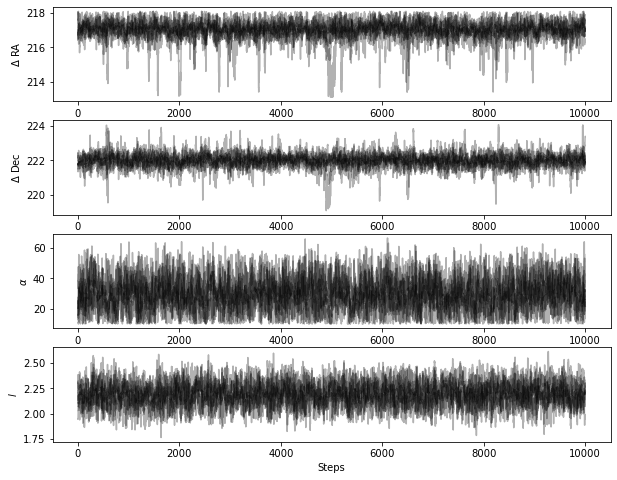

In [11]:
# We load in the results of the MCMC from the compressed pickle file
# the pyklip code has generated for us

chain_info = pickle.load(open(pklout, "rb"))

# First, let's plot the chains

fig=plt.figure(figsize=(10,8))
# plot RA offset
ax1 = fig.add_subplot(411)
ax1.plot(chain_info[:,:,0].T, '-', color='k', alpha=0.3)
ax1.set_xlabel("Steps")
ax1.set_ylabel(r"$\Delta$ RA")

# plot Dec offset
ax2 = fig.add_subplot(412)
ax2.plot(chain_info[:,:,1].T, '-', color='k', alpha=0.3)
ax2.set_xlabel("Steps")
ax2.set_ylabel(r"$\Delta$ Dec")

# plot flux scaling
ax3 = fig.add_subplot(413)
ax3.plot(chain_info[:,:,2].T, '-', color='k', alpha=0.3)
ax3.set_xlabel("Steps")
ax3.set_ylabel(r"$\alpha$")

# plot hyperparameters.. we only have one for this example: the correlation length
ax4 = fig.add_subplot(414)
ax4.plot(chain_info[:,:,3].T, '-', color='k', alpha=0.3)
ax4.set_xlabel("Steps")
ax4.set_ylabel(r"$l$")

plt.savefig(outputdir+"/"+prefix+'_BKA_chain'+PSFpath.replace('do',str(FWHM))+'.png')

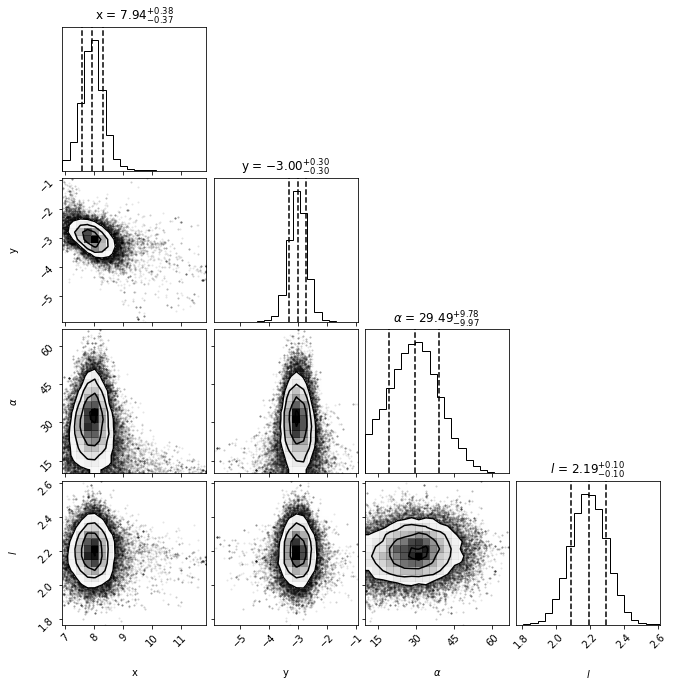

In [12]:
# the other two figures are easier to make, because there are methods
# already written

# Second is the corner plot
fig = fma.make_corner_plot()
plt.savefig(outputdir+"/"+prefix+'_BKA_corner'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)

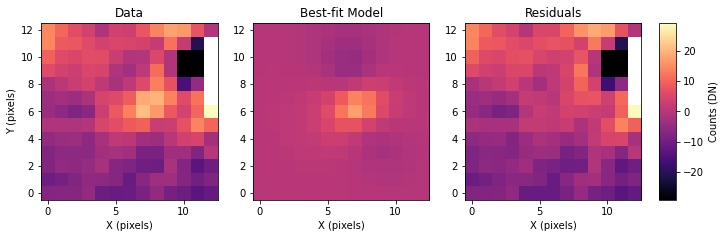

In [13]:
# And third is the model comparison and residuals
fig, resids = fma.best_fit_and_residuals()
plt.savefig(outputdir+"/"+prefix+'_BKA_residuals'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)

Congratulations! You've reached the written end of this notebook, but there's so much more out there. I believe in you.

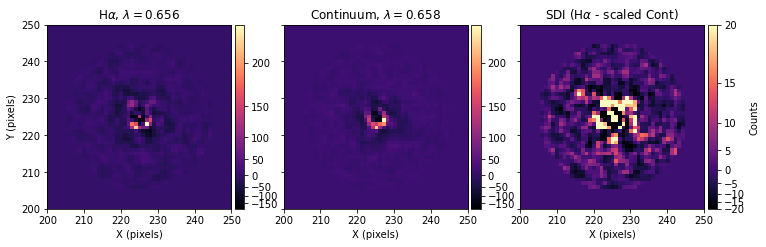

In [14]:
if prefix == 'Cont':
    cont = fits.getdata(outputdir+'\\Cont-klipped-KLmodes-all.fits')[0]
    line = fits.getdata(outputdir.replace(prefix,'Ha')+'\\Ha-klipped-KLmodes-all.fits')[0]
else:
    line = fits.getdata(outputdir+'\\Ha-klipped-KLmodes-all.fits')[0]
    cont = fits.getdata(outputdir.replace(prefix,'Cont')+'\\Cont-klipped-KLmodes-all.fits')[0]

line[np.isnan(line)] = np.nanmedian(line)
cont[np.isnan(cont)] = np.nanmedian(cont)

inner = 0

line = domask(line, inn=inner)
cont = domask(cont, inn=inner)

scale = 0.9

n2 = 20

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch, SinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

fig = plt.figure(figsize=(12, 4))

# make residual map
residual_map = (line)-(cont*scale)
residual_map = residual_map/np.nanstd(residual_map)

# normalize all images to same scale
colornorm = matplotlib.colors.Normalize(vmin=np.nanpercentile(line, 0.03),
                                        vmax=np.nanpercentile(line, 99.7))

# plot the data_stamp
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(line, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()))
ax1.invert_yaxis()
ax1.set_title(r"H$\alpha$, $\lambda=0.656$")
ax1.set_xlabel("X (pixels)")
ax1.set_ylabel("Y (pixels)")
ax1.set_xlim(200,250)
ax1.set_ylim(200,250)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = fig.colorbar(im1, cax=cax1)#, ticks=[-500, 0, 500])

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(cont, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()))
ax2.invert_yaxis()
ax2.set(yticklabels=[])
ax2.set_title(r"Continuum, $\lambda=0.658$")
ax2.set_xlabel("X (pixels)")
ax2.set_xlim(200,250)
ax2.set_ylim(200,250)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cb2 = fig.colorbar(im1, cax=cax2)#, ticks=[-500, 0, 500])

ax3 = fig.add_subplot(133)
im3 = ax3.imshow(residual_map, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()), vmin=-n2, vmax=n2)
ax3.invert_yaxis()
ax3.set(yticklabels=[])
ax3.set_title(r"SDI (H$\alpha$ - scaled Cont)")
ax3.set_xlabel("X (pixels)")
ax3.set_xlim(200,250)
ax3.set_ylim(200,250)

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
cb3 = fig.colorbar(im3, cax=cax3)#, ticks=[-n2, 0, n2])
cb3.set_label("Counts")

plt.savefig(outputdir+'\\SDI'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)

(200.0, 250.0)

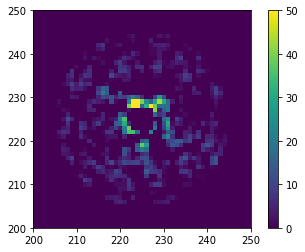

In [15]:
plt.imshow(domask(residual_map/np.std(residual_map), inn=3), vmin=0, vmax=50)
plt.colorbar()
plt.xlim(200,250)
plt.ylim(200,250)
#plt.savefig('2018_snrmap.png')

In [16]:
fma.raw_flux.bestfit*np.sum(fm.psf2.flatten())/969733

0.02951923145788905

In [17]:
np.sum(fm.psf2.flatten())

10.197810319111683

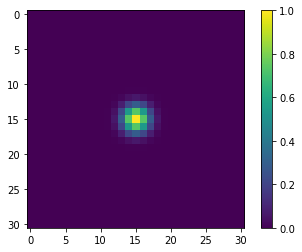

In [18]:
plt.imshow(fm.psf2[0])
plt.colorbar()

In [19]:
from photutils import CircularAperture, CircularAnnulus
positions = [(15., 15.)]
aperture = CircularAperture(positions, r=7.)

annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=13.)

import numpy as np
from photutils import aperture_photometry
data = fm.psf2[0]#np.ones((100, 100))

apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(data, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)
phot_table['aperture_sum_0']-((phot_table['aperture_sum_1']/annulus_aperture.area)*aperture.area)


 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1      15      15      10.197805  1.2833043e-12


10.197805


In [20]:
(fma.raw_flux.bestfit*181.46)/282080

1.805755320031999